In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, GlobalAveragePooling2D,GlobalMaxPooling2D
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the path to your dataset
data_path_train = "/kaggle/input/covid19-segmented-data/Covid19 Segmented/Train"
data_path_val="/kaggle/input/covid19-segmented-data/Covid19 Segmented/Val"
# Specify parameters
img_size = (256, 256)
batch_size = 32

# Use ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    data_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)
validation_generator = val_datagen.flow_from_directory(
    data_path_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1058 images belonging to 2 classes.
Found 356 images belonging to 2 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Corona Virus Disease
1 : Normal


In [ ]:
from tensorflow.keras.optimizers import Adam
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in base_model.layers:
    layer.trainable=False

x=base_model.get_layer(index=-1).output
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(base_model.input,x)

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
history=model.fit(train_generator,epochs=3,validation_data=validation_generator)

Epoch 1/3


I0000 00:00:1709230224.642188      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 [==============================] - 45s 948ms/step - loss: 0.2722 - accuracy: 0.9083 - val_loss: 0.1387 - val_accuracy: 0.9551
Epoch 2/3
34/34 [==============================] - 26s 754ms/step - loss: 0.1041 - accuracy: 0.9594 - val_loss: 0.1290 - val_accuracy: 0.9438
Epoch 3/3
34/34 [==============================] - 26s 772ms/step - loss: 0.0587 - accuracy: 0.9764 - val_loss: 0.0507 - val_accuracy: 0.9775


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test="/kaggle/input/covid19-segmented-data/Covid19 Segmented/Test"
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model on the test set
results = model.evaluate(_generator)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

Found 260 images belonging to 2 classes.
9/9 [==============================] - 2s 157ms/step - loss: 0.1101 - accuracy: 0.9654
Test Loss: 0.11010931432247162
Test Accuracy: 0.9653846025466919


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(test_generator)
predictions=(predictions>0.5).astype(int)
y_true = test_generator.classes
print(classification_report(y_true,predictions))

9/9 [==============================] - 2s 101ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       130
           1       0.98      0.95      0.96       130

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



In [ ]:
model.save("BinarySegmented_InceptionV3.h5")

9/9 [==============================] - 1s 95ms/step


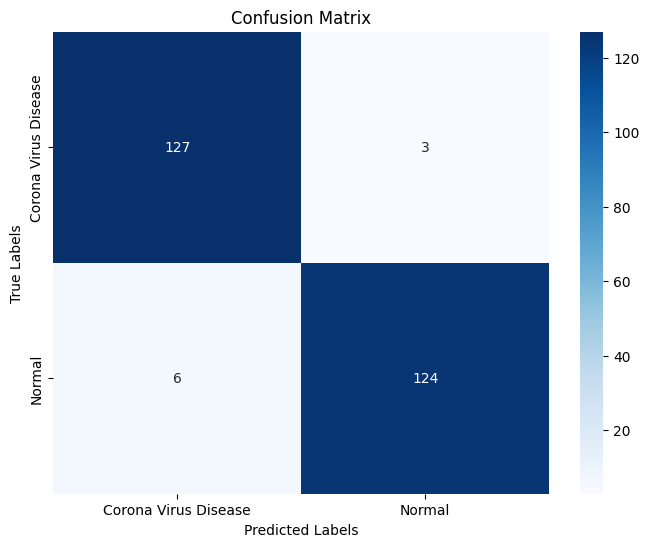

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

predictions=(predictions>0.5).astype(int)
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels,predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

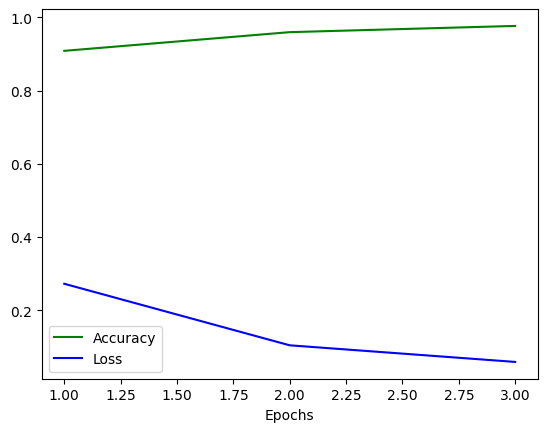

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,4),history.history['accuracy'],color='g',label='Accuracy')
plt.plot(range(1,4),history.history['loss'],color='blue',label='Loss')
plt.xlabel('Epochs')
plt.legend()

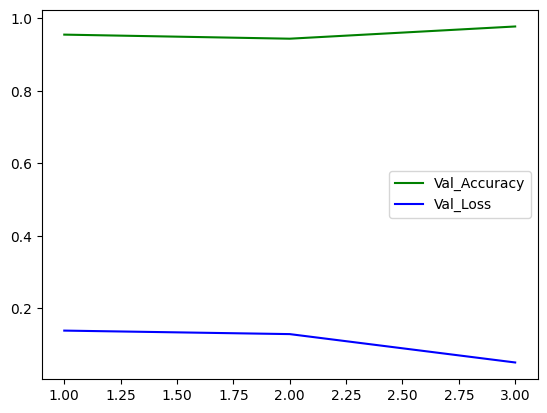

In [ ]:
plt.plot(range(1,4),history.history['val_accuracy'],color='g',label='Val_Accuracy')
plt.plot(range(1,4),history.history['val_loss'],color='b',label='Val_Loss')
plt.legend()